In [1]:
# original gan architectures and training codes from https://github.com/lyeoni/pytorch-mnist-GAN

# prerequisites
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt

# library that computes FID https://github.com/mseitzer/pytorch-fid
!pip install pytorch-fid

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set seed for reproducibility

seed = 0

torch.manual_seed(seed)

In [2]:
# Taken from the official lookahead's paper implementation https://github.com/michaelrzhang/lookahead

# Lookahead optimizer
from collections import defaultdict

import torch
from torch.optim.optimizer import Optimizer


class Lookahead(Optimizer):
    r"""PyTorch implementation of the lookahead wrapper.
    Lookahead Optimizer: https://arxiv.org/abs/1907.08610
    """

    def __init__(self, optimizer, la_steps=5, la_alpha=0.8, pullback_momentum="none"):
        """optimizer: inner optimizer
        la_steps (int): number of lookahead steps
        la_alpha (float): linear interpolation factor. 1.0 recovers the inner optimizer.
        pullback_momentum (str): change to inner optimizer momentum on interpolation update
        """
        self.optimizer = optimizer
        self._la_step = 0  # counter for inner optimizer
        self.la_alpha = la_alpha
        self._total_la_steps = la_steps
        pullback_momentum = pullback_momentum.lower()
        assert pullback_momentum in ["reset", "pullback", "none"]
        self.pullback_momentum = pullback_momentum

        self.state = defaultdict(dict)

        # Cache the current optimizer parameters
        for group in optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['cached_params'] = torch.zeros_like(p.data)
                param_state['cached_params'].copy_(p.data)
                if self.pullback_momentum == "pullback":
                    param_state['cached_mom'] = torch.zeros_like(p.data)

    def __getstate__(self):
        return {
            'state': self.state,
            'optimizer': self.optimizer,
            'la_alpha': self.la_alpha,
            '_la_step': self._la_step,
            '_total_la_steps': self._total_la_steps,
            'pullback_momentum': self.pullback_momentum
        }

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_la_step(self):
        return self._la_step

    def state_dict(self):
        return self.optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict)

    def _backup_and_load_cache(self):
        """Useful for performing evaluation on the slow weights (which typically generalize better)
        """
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['backup_params'] = torch.zeros_like(p.data)
                param_state['backup_params'].copy_(p.data)
                p.data.copy_(param_state['cached_params'])

    def _clear_and_load_backup(self):
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                p.data.copy_(param_state['backup_params'])
                del param_state['backup_params']

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def step(self, closure=None):
        """Performs a single Lookahead optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = self.optimizer.step(closure)
        self._la_step += 1

        if self._la_step >= self._total_la_steps:
            self._la_step = 0
            # Lookahead and cache the current optimizer parameters
            for group in self.optimizer.param_groups:
                for p in group['params']:
                    param_state = self.state[p]
                    p.data.mul_(self.la_alpha).add_(param_state['cached_params'], alpha=1.0 - self.la_alpha)  # crucial line
                    param_state['cached_params'].copy_(p.data)
                    if self.pullback_momentum == "pullback":
                        internal_momentum = self.optimizer.state[p]["momentum_buffer"]
                        self.optimizer.state[p]["momentum_buffer"] = internal_momentum.mul_(self.la_alpha).add_(
                            1.0 - self.la_alpha, param_state["cached_mom"])
                        param_state["cached_mom"] = self.optimizer.state[p]["momentum_buffer"]
                    elif self.pullback_momentum == "reset":
                        self.optimizer.state[p]["momentum_buffer"] = torch.zeros_like(p.data)

        return loss

In [3]:
checkpoint_path = './checkpoints/'

In [4]:
# batch size.
bs = 100

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

# Define networks

In [5]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, self.fc3.out_features)
        self.fc5 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.leaky_relu(self.fc4(x), 0.2)
        return torch.tanh(self.fc5(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [6]:
lrs = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

In [7]:
# loss fuction
criterion = nn.BCELoss() 

# learning rate
lr = 0.00001 # 0.0001 for adam mnist, 0.001 for SGD both dataset

# number of epochs every number is trained for
n_epoch = 200

# size of the set of pictures generated for FID computation
G_set_size = 10000

# dimension of the generation seeds
z_dim = 100

optimizers = []
optimizers.append('Adam')
optimizers.append('Lookahead Adam')
optimizers.append('SGD')
optimizers.append('Lookahead SGD')

In [8]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)

    d = D_output.clone()
    d[d >= 0.5] = 1
    d[d < 0.5] = 0

    D_batch_real_acc = len(d[d==1])/len(y_real)

    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = torch.randn(bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(bs, 1).to(device)

    D_output = D(x_fake)

    d = D_output.clone()
    d[d >= 0.5] = 1
    d[d < 0.5] = 0

    D_batch_fake_acc = len(d[d==0])/len(y_fake)

    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item(), D_batch_real_acc, D_batch_fake_acc

In [9]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.randn(bs, z_dim).to(device)
    y = torch.ones(bs, 1).to(device)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    d = D_output.clone()
    d[d >= 0.5] = 1
    d[d < 0.5] = 0

    # How many times G tricks D. (Hope it's correct?)
    G_batch_acc = len(d[d==1])/len(y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item(), G_batch_acc

# MNIST

### Load data

In [10]:
dataset_name = 'MNIST'

# load MNIST data
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# Save pictures from test dataset to computer FID later
count = 0
for i, batch in enumerate(test_loader):
    for b in range(len(batch[0])):
        save_image(batch[0][b], './FID_data/test_pictures/img' + str(count) + '.png')
        count += 1
    print('Saving test pictures : {}/{}...'.format(count, len(test_loader)*bs), end='\r')

In [11]:
# save first batch as a picture
save_image(next(iter(train_loader))[0], './{}_batch1'.format(dataset_name) + '.png')

In [12]:
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

# define generator and discriminator
G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

### Train and evaluate networks

In [13]:
###### https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

FIDs_dic = {}

for n in range(1, 4):
    print('Run {}:'.format(n))
    
    for opt_name in optimizers:
        print('Training using ' + opt_name)
    
        G_loss_per_epoch = []
        D_loss_per_epoch = []
        
        D_real_acc_per_epoch = []
        D_fake_acc_per_epoch = []
        G_acc_per_epoch = []
        
        FIDs = []
        list_epochs = []
    
        G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
        D = Discriminator(mnist_dim).to(device)
        
        if opt_name == 'Adam':
            lr = 0.0001
            G_optimizer = optim.Adam(G.parameters(), lr = lr)
            D_optimizer = optim.Adam(D.parameters(), lr = lr)
        elif opt_name == 'Lookahead Adam':
            lr = 0.0001
            G_optimizer = optim.Adam(G.parameters(), lr = lr)
            G_optimizer = Lookahead(G_optimizer, la_steps=5, la_alpha=0.8)
            D_optimizer = optim.Adam(D.parameters(), lr = lr)
            D_optimizer = Lookahead(D_optimizer, la_steps=5, la_alpha=0.8)
        elif opt_name == 'SGD':
            lr = 0.001
            G_optimizer = optim.SGD(G.parameters(), lr = lr, momentum=0.9)
            D_optimizer = optim.SGD(D.parameters(), lr = lr, momentum=0.9)
        elif opt_name == 'Lookahead SGD':
            lr = 0.001
            G_optimizer = optim.SGD(G.parameters(), lr = lr, momentum=0.9)
            G_optimizer = Lookahead(G_optimizer, la_steps=5, la_alpha=0.8)
            D_optimizer = optim.SGD(D.parameters(), lr = lr, momentum=0.9)
            D_optimizer = Lookahead(D_optimizer, la_steps=5, la_alpha=0.8)
        
        for epoch in range(1, n_epoch+1):
            D_losses, G_losses = [], []
            D_real_accs, D_fake_accs, G_accs = [], [], []
            
            for batch_idx, (x, _) in enumerate(train_loader):
                D_current_loss, D_batch_real_acc, D_batch_fake_acc = D_train(x)
                G_current_loss, G_batch_acc = G_train(x)
        
                D_real_accs.append(D_batch_real_acc)
                D_fake_accs.append(D_batch_fake_acc)
                G_accs.append(G_batch_acc)
        
                D_losses.append(D_current_loss)
                G_losses.append(G_current_loss)
        
            G_loss = torch.mean(torch.FloatTensor(G_losses))
            D_loss = torch.mean(torch.FloatTensor(D_losses))
        
            G_loss_per_epoch.append(G_loss.item())
            D_loss_per_epoch.append(D_loss.item())
        
            D_real_acc_per_epoch.append(torch.mean(torch.FloatTensor(D_real_accs)).item())
            D_fake_acc_per_epoch.append(torch.mean(torch.FloatTensor(D_fake_accs)).item())
            G_acc_per_epoch.append(torch.mean(torch.FloatTensor(G_accs)).item())
            
            print('[%d/%d]: loss_d: %.7f, loss_g: %.3f' % ((epoch), n_epoch, D_loss, G_loss)) 
            
            count = 0
            if epoch == 1 or epoch%20 == 0 or epoch == n_epoch: # every n epochs and after last epoch
    
                # save pictures generated with generator and compute current FID
                for i in range(int(G_set_size/bs)):
                    G_seeds = torch.randn(bs, z_dim).to(device)
                    G_pictures = G(G_seeds)
                    G_pictures = G_pictures.view(G_pictures.size(0), 1, 28, 28)
        
                    for b in range(bs):
                        save_image(G_pictures[b], './FID_data/generated_pictures/img' + str(count) + '.png')
                        count += 1
                    print('Generating pictures : {}/{}...'.format(count, G_set_size), end='\r')
                print()
                print('Computing FID...', end='\r')
                fid = !python -m pytorch_fid "./FID_data/generated_pictures/" "./FID_data/test_pictures/"
                fid = float(fid[-1].replace('FID:  ', ''))
                print('FID : {}'.format(fid), end='\r')
                print()
                FIDs.append(fid) 
                list_epochs.append(epoch)
                
                # generate and save samples
                samples_per_epoch = 1
                for sample_nbr in range(1, samples_per_epoch+1):
                    with torch.no_grad():
                        test_z = torch.randn(bs, z_dim).to(device)
                        generated = G(test_z)
                        save_image(generated.view(generated.size(0), 1, 28, 28), './{}_{}_epoch_{}_run_{}'.format(dataset_name, opt_name, epoch, n) + '.png')
    
        FIDs_dic[opt_name + str(n)] = FIDs

Run 1:
Training using Adam
[1/200]: loss_d: 1.2095982, loss_g: 1.053
Generating pictures : 10000/10000...
FID : 242.33152997938177
[2/200]: loss_d: 1.2787131, loss_g: 0.902
[3/200]: loss_d: 0.3727446, loss_g: 6.474
[4/200]: loss_d: 0.0010250, loss_g: 12.894
[5/200]: loss_d: 0.0026603, loss_g: 13.350
[6/200]: loss_d: 0.0004528, loss_g: 13.689
[7/200]: loss_d: 0.0000894, loss_g: 16.413
[8/200]: loss_d: 0.0000354, loss_g: 17.282
[9/200]: loss_d: 0.0000251, loss_g: 17.674
[10/200]: loss_d: 0.0032395, loss_g: 14.389
[11/200]: loss_d: 0.0000571, loss_g: 17.377
[12/200]: loss_d: 0.0000216, loss_g: 19.100
[13/200]: loss_d: 0.0000221, loss_g: 22.561
[14/200]: loss_d: 0.0000052, loss_g: 21.246
[15/200]: loss_d: 0.0000034, loss_g: 21.585
[16/200]: loss_d: 0.0000025, loss_g: 21.731
[17/200]: loss_d: 0.0000019, loss_g: 22.719
[18/200]: loss_d: 0.0000013, loss_g: 23.433
[19/200]: loss_d: 0.0000009, loss_g: 23.729
[20/200]: loss_d: 0.0000006, loss_g: 24.091
Generating pictures : 10000/10000...
FID : 

[173/200]: loss_d: 0.0000000, loss_g: 57.832
[174/200]: loss_d: 0.0000000, loss_g: 57.825
[175/200]: loss_d: 0.0000000, loss_g: 57.796
[176/200]: loss_d: 0.0000000, loss_g: 57.815
[177/200]: loss_d: 0.0000000, loss_g: 57.761
[178/200]: loss_d: 0.0000000, loss_g: 57.756
[179/200]: loss_d: 0.0000000, loss_g: 57.840
[180/200]: loss_d: 0.0000000, loss_g: 57.740
Generating pictures : 10000/10000...
FID : 366.5260939586253
[181/200]: loss_d: 0.0000000, loss_g: 57.723
[182/200]: loss_d: 0.0000000, loss_g: 57.772
[183/200]: loss_d: 0.0000000, loss_g: 57.767
[184/200]: loss_d: 0.0000000, loss_g: 57.708
[185/200]: loss_d: 0.0000000, loss_g: 57.621
[186/200]: loss_d: 0.0000000, loss_g: 57.641
[187/200]: loss_d: 0.0000000, loss_g: 57.613
[188/200]: loss_d: 0.0000000, loss_g: 57.523
[189/200]: loss_d: 0.0000000, loss_g: 57.573
[190/200]: loss_d: 0.0000000, loss_g: 57.655
[191/200]: loss_d: 0.0000000, loss_g: 57.615
[192/200]: loss_d: 0.0000000, loss_g: 57.652
[193/200]: loss_d: 0.0000000, loss_g: 5

[147/200]: loss_d: 1.2981046, loss_g: 0.844
[148/200]: loss_d: 1.2979320, loss_g: 0.843
[149/200]: loss_d: 1.2990563, loss_g: 0.838
[150/200]: loss_d: 1.3016626, loss_g: 0.838
[151/200]: loss_d: 1.2998238, loss_g: 0.839
[152/200]: loss_d: 1.3071880, loss_g: 0.828
[153/200]: loss_d: 1.3035427, loss_g: 0.830
[154/200]: loss_d: 1.2973543, loss_g: 0.840
[155/200]: loss_d: 1.3040348, loss_g: 0.842
[156/200]: loss_d: 1.2940427, loss_g: 0.845
[157/200]: loss_d: 1.2920493, loss_g: 0.847
[158/200]: loss_d: 1.3033649, loss_g: 0.834
[159/200]: loss_d: 1.3049244, loss_g: 0.836
[160/200]: loss_d: 1.3017526, loss_g: 0.841
Generating pictures : 10000/10000...
FID : 23.849514677523246
[161/200]: loss_d: 1.3055204, loss_g: 0.827
[162/200]: loss_d: 1.2989886, loss_g: 0.842
[163/200]: loss_d: 1.3015771, loss_g: 0.828
[164/200]: loss_d: 1.3019086, loss_g: 0.834
[165/200]: loss_d: 1.2995272, loss_g: 0.839
[166/200]: loss_d: 1.3107692, loss_g: 0.822
[167/200]: loss_d: 1.3046587, loss_g: 0.827
[168/200]: los

Generating pictures : 10000/10000...
FID : 273.23756637635097
[121/200]: loss_d: 0.0000220, loss_g: 15.216
[122/200]: loss_d: 0.0000148, loss_g: 15.624
[123/200]: loss_d: 0.0000360, loss_g: 14.715
[124/200]: loss_d: 0.0000455, loss_g: 14.338
[125/200]: loss_d: 0.0000351, loss_g: 14.603
[126/200]: loss_d: 0.0000211, loss_g: 14.673
[127/200]: loss_d: 0.0000166, loss_g: 15.149
[128/200]: loss_d: 0.0000159, loss_g: 15.230
[129/200]: loss_d: 0.0000143, loss_g: 15.506
[130/200]: loss_d: 0.0000334, loss_g: 14.613
[131/200]: loss_d: 0.0000390, loss_g: 14.480
[132/200]: loss_d: 0.0000228, loss_g: 14.790
[133/200]: loss_d: 0.0000359, loss_g: 14.742
[134/200]: loss_d: 0.0000266, loss_g: 14.833
[135/200]: loss_d: 0.0000204, loss_g: 14.870
[136/200]: loss_d: 0.0000139, loss_g: 15.515
[137/200]: loss_d: 0.0000206, loss_g: 15.232
[138/200]: loss_d: 0.0000313, loss_g: 14.445
[139/200]: loss_d: 0.0001111, loss_g: 13.879
[140/200]: loss_d: 0.0016094, loss_g: 12.896
Generating pictures : 10000/10000...
F

[94/200]: loss_d: 0.3872561, loss_g: 2.401
[95/200]: loss_d: 0.3851736, loss_g: 2.378
[96/200]: loss_d: 0.4027747, loss_g: 2.339
[97/200]: loss_d: 0.3905060, loss_g: 2.370
[98/200]: loss_d: 0.3903324, loss_g: 2.375
[99/200]: loss_d: 0.3956521, loss_g: 2.369
[100/200]: loss_d: 0.3926331, loss_g: 2.363
Generating pictures : 10000/10000...
FID : 93.60309120684047
[101/200]: loss_d: 0.3973206, loss_g: 2.359
[102/200]: loss_d: 0.3964444, loss_g: 2.345
[103/200]: loss_d: 0.4054756, loss_g: 2.327
[104/200]: loss_d: 0.4084269, loss_g: 2.311
[105/200]: loss_d: 0.4123790, loss_g: 2.312
[106/200]: loss_d: 0.4140314, loss_g: 2.336
[107/200]: loss_d: 0.4132286, loss_g: 2.329
[108/200]: loss_d: 0.4361660, loss_g: 2.281
[109/200]: loss_d: 0.4350946, loss_g: 2.275
[110/200]: loss_d: 0.4404272, loss_g: 2.272
[111/200]: loss_d: 0.4274212, loss_g: 2.312
[112/200]: loss_d: 0.4244516, loss_g: 2.315
[113/200]: loss_d: 0.4322838, loss_g: 2.287
[114/200]: loss_d: 0.4338906, loss_g: 2.302
[115/200]: loss_d: 0.

[67/200]: loss_d: 0.0000000, loss_g: 52.680
[68/200]: loss_d: 0.0000000, loss_g: 52.399
[69/200]: loss_d: 0.0000000, loss_g: 50.584
[70/200]: loss_d: 0.0000000, loss_g: 50.254
[71/200]: loss_d: 0.0000000, loss_g: 50.253
[72/200]: loss_d: 0.0000000, loss_g: 50.201
[73/200]: loss_d: 0.0000000, loss_g: 50.096
[74/200]: loss_d: 0.0000000, loss_g: 50.128
[75/200]: loss_d: 0.0000000, loss_g: 50.079
[76/200]: loss_d: 0.0000000, loss_g: 49.965
[77/200]: loss_d: 0.0000000, loss_g: 49.795
[78/200]: loss_d: 0.0000000, loss_g: 49.771
[79/200]: loss_d: 0.0000000, loss_g: 49.805
[80/200]: loss_d: 0.0000000, loss_g: 49.796
Generating pictures : 10000/10000...
FID : 382.84271416299964
[81/200]: loss_d: 0.0000000, loss_g: 49.805
[82/200]: loss_d: 0.0000000, loss_g: 49.742
[83/200]: loss_d: 0.0000000, loss_g: 49.758
[84/200]: loss_d: 0.0000000, loss_g: 49.733
[85/200]: loss_d: 0.0000000, loss_g: 49.651
[86/200]: loss_d: 0.0000000, loss_g: 49.639
[87/200]: loss_d: 0.0000000, loss_g: 49.579
[88/200]: loss

[39/200]: loss_d: 0.9625385, loss_g: 1.444
[40/200]: loss_d: 0.9765965, loss_g: 1.414
Generating pictures : 10000/10000...
FID : 67.62063202086955
[41/200]: loss_d: 0.9798371, loss_g: 1.427
[42/200]: loss_d: 0.9811623, loss_g: 1.390
[43/200]: loss_d: 0.9926257, loss_g: 1.393
[44/200]: loss_d: 1.0159829, loss_g: 1.337
[45/200]: loss_d: 1.0329019, loss_g: 1.310
[46/200]: loss_d: 1.0312884, loss_g: 1.304
[47/200]: loss_d: 1.0426604, loss_g: 1.289
[48/200]: loss_d: 1.0507711, loss_g: 1.260
[49/200]: loss_d: 1.0653497, loss_g: 1.255
[50/200]: loss_d: 1.0583504, loss_g: 1.263
[51/200]: loss_d: 1.0857581, loss_g: 1.206
[52/200]: loss_d: 1.0841564, loss_g: 1.205
[53/200]: loss_d: 1.0888042, loss_g: 1.209
[54/200]: loss_d: 1.1009027, loss_g: 1.176
[55/200]: loss_d: 1.1183317, loss_g: 1.151
[56/200]: loss_d: 1.1201954, loss_g: 1.142
[57/200]: loss_d: 1.1304301, loss_g: 1.124
[58/200]: loss_d: 1.1386658, loss_g: 1.118
[59/200]: loss_d: 1.1425139, loss_g: 1.104
[60/200]: loss_d: 1.1460919, loss_g:

[13/200]: loss_d: 0.0078392, loss_g: 12.027
[14/200]: loss_d: 0.0249833, loss_g: 10.832
[15/200]: loss_d: 0.0311150, loss_g: 10.739
[16/200]: loss_d: 0.0278032, loss_g: 10.348
[17/200]: loss_d: 0.0237572, loss_g: 11.243
[18/200]: loss_d: 0.0142988, loss_g: 11.100
[19/200]: loss_d: 0.0295463, loss_g: 10.161
[20/200]: loss_d: 0.0357305, loss_g: 10.034
Generating pictures : 10000/10000...
FID : 269.6580147627774
[21/200]: loss_d: 0.0193455, loss_g: 10.595
[22/200]: loss_d: 0.0177326, loss_g: 10.658
[23/200]: loss_d: 0.0076939, loss_g: 12.783
[24/200]: loss_d: 0.0003667, loss_g: 15.062
[25/200]: loss_d: 0.0000914, loss_g: 15.912
[26/200]: loss_d: 0.0001378, loss_g: 16.051
[27/200]: loss_d: 0.0154453, loss_g: 12.440
[28/200]: loss_d: 0.0081203, loss_g: 11.621
[29/200]: loss_d: 0.0121620, loss_g: 12.346
[30/200]: loss_d: 0.0288964, loss_g: 10.812
[31/200]: loss_d: 0.0203534, loss_g: 11.239
[32/200]: loss_d: 0.0018145, loss_g: 13.778
[33/200]: loss_d: 0.0110394, loss_g: 12.552
[34/200]: loss_

[185/200]: loss_d: 0.0000013, loss_g: 18.455
[186/200]: loss_d: 0.0000011, loss_g: 18.520
[187/200]: loss_d: 0.0000011, loss_g: 18.574
[188/200]: loss_d: 0.0000017, loss_g: 18.581
[189/200]: loss_d: 0.0000011, loss_g: 18.621
[190/200]: loss_d: 0.0000011, loss_g: 18.678
[191/200]: loss_d: 0.0000010, loss_g: 18.749
[192/200]: loss_d: 0.0000011, loss_g: 18.757
[193/200]: loss_d: 0.0000013, loss_g: 18.806
[194/200]: loss_d: 0.0000011, loss_g: 18.830
[195/200]: loss_d: 0.0000009, loss_g: 18.846
[196/200]: loss_d: 0.0000011, loss_g: 18.896
[197/200]: loss_d: 0.0000010, loss_g: 18.888
[198/200]: loss_d: 0.0000013, loss_g: 18.901
[199/200]: loss_d: 0.0000011, loss_g: 18.925
[200/200]: loss_d: 0.0000009, loss_g: 18.940
Generating pictures : 10000/10000...
FID : 307.075696186713
Training using Lookahead SGD
[1/200]: loss_d: 0.4299775, loss_g: 1.260
Generating pictures : 10000/10000...
FID : 240.56522165376552
[2/200]: loss_d: 0.4295041, loss_g: 2.820
[3/200]: loss_d: 0.2982063, loss_g: 4.628
[4/

Generating pictures : 10000/10000...
FID : 52.37284526910517
[161/200]: loss_d: 0.6884736, loss_g: 1.797
[162/200]: loss_d: 0.6937163, loss_g: 1.796
[163/200]: loss_d: 0.6960921, loss_g: 1.801
[164/200]: loss_d: 0.7004939, loss_g: 1.785
[165/200]: loss_d: 0.6982840, loss_g: 1.784
[166/200]: loss_d: 0.6960136, loss_g: 1.777
[167/200]: loss_d: 0.7013312, loss_g: 1.786
[168/200]: loss_d: 0.7093230, loss_g: 1.757
[169/200]: loss_d: 0.7105482, loss_g: 1.762
[170/200]: loss_d: 0.7169866, loss_g: 1.746
[171/200]: loss_d: 0.7121169, loss_g: 1.758
[172/200]: loss_d: 0.6948713, loss_g: 1.789
[173/200]: loss_d: 0.7155923, loss_g: 1.759
[174/200]: loss_d: 0.7258615, loss_g: 1.731
[175/200]: loss_d: 0.7153935, loss_g: 1.754
[176/200]: loss_d: 0.7225155, loss_g: 1.734
[177/200]: loss_d: 0.7295385, loss_g: 1.706
[178/200]: loss_d: 0.7294993, loss_g: 1.738
[179/200]: loss_d: 0.7339590, loss_g: 1.709
[180/200]: loss_d: 0.7369887, loss_g: 1.710
Generating pictures : 10000/10000...
FID : 50.4952866108566

[136/200]: loss_d: 1.3080380, loss_g: 0.818
[137/200]: loss_d: 1.3033904, loss_g: 0.838
[138/200]: loss_d: 1.3055896, loss_g: 0.825
[139/200]: loss_d: 1.3059024, loss_g: 0.825
[140/200]: loss_d: 1.3116862, loss_g: 0.823
Generating pictures : 10000/10000...
FID : 29.82820300402352
[141/200]: loss_d: 1.3086207, loss_g: 0.821
[142/200]: loss_d: 1.3162538, loss_g: 0.810
[143/200]: loss_d: 1.3113360, loss_g: 0.820
[144/200]: loss_d: 1.3161494, loss_g: 0.814
[145/200]: loss_d: 1.3147378, loss_g: 0.810
[146/200]: loss_d: 1.3184029, loss_g: 0.807
[147/200]: loss_d: 1.3039863, loss_g: 0.830
[148/200]: loss_d: 1.3048795, loss_g: 0.829
[149/200]: loss_d: 1.3173728, loss_g: 0.808
[150/200]: loss_d: 1.3113515, loss_g: 0.820
[151/200]: loss_d: 1.3106298, loss_g: 0.818
[152/200]: loss_d: 1.3141115, loss_g: 0.818
[153/200]: loss_d: 1.3201764, loss_g: 0.808
[154/200]: loss_d: 1.3154739, loss_g: 0.811
[155/200]: loss_d: 1.3228537, loss_g: 0.799
[156/200]: loss_d: 1.3217045, loss_g: 0.801
[157/200]: loss

[110/200]: loss_d: 1.2657678, loss_g: 0.897
[111/200]: loss_d: 1.2611449, loss_g: 0.901
[112/200]: loss_d: 1.2734369, loss_g: 0.884
[113/200]: loss_d: 1.2722310, loss_g: 0.884
[114/200]: loss_d: 1.2679043, loss_g: 0.903
[115/200]: loss_d: 1.2735732, loss_g: 0.886
[116/200]: loss_d: 1.2732077, loss_g: 0.879
[117/200]: loss_d: 1.2753222, loss_g: 0.874
[118/200]: loss_d: 1.2760651, loss_g: 0.878
[119/200]: loss_d: 1.2790357, loss_g: 0.869
[120/200]: loss_d: 1.2742099, loss_g: 0.880
Generating pictures : 10000/10000...
FID : 27.619812614946056
[121/200]: loss_d: 1.2755193, loss_g: 0.880
[122/200]: loss_d: 1.2813388, loss_g: 0.873
[123/200]: loss_d: 1.2761624, loss_g: 0.873
[124/200]: loss_d: 1.2808828, loss_g: 0.873
[125/200]: loss_d: 1.2801093, loss_g: 0.873
[126/200]: loss_d: 1.2794356, loss_g: 0.870
[127/200]: loss_d: 1.2833705, loss_g: 0.863
[128/200]: loss_d: 1.2824731, loss_g: 0.865
[129/200]: loss_d: 1.2849143, loss_g: 0.863
[130/200]: loss_d: 1.2847077, loss_g: 0.862
[131/200]: los

[83/200]: loss_d: 0.0125218, loss_g: 11.323
[84/200]: loss_d: 0.0350159, loss_g: 10.237
[85/200]: loss_d: 0.0096243, loss_g: 11.088
[86/200]: loss_d: 0.0094239, loss_g: 10.288
[87/200]: loss_d: 0.0189121, loss_g: 10.402
[88/200]: loss_d: 0.0095543, loss_g: 11.306
[89/200]: loss_d: 0.0062013, loss_g: 12.699
[90/200]: loss_d: 0.0259572, loss_g: 10.372
[91/200]: loss_d: 0.0177230, loss_g: 11.435
[92/200]: loss_d: 0.0111400, loss_g: 12.460
[93/200]: loss_d: 0.0245704, loss_g: 10.822
[94/200]: loss_d: 0.0034183, loss_g: 11.519
[95/200]: loss_d: 0.0246603, loss_g: 11.543
[96/200]: loss_d: 0.0197699, loss_g: 10.164
[97/200]: loss_d: 0.0051287, loss_g: 11.031
[98/200]: loss_d: 0.0401237, loss_g: 11.515
[99/200]: loss_d: 0.0062945, loss_g: 12.478
[100/200]: loss_d: 0.0136402, loss_g: 11.367
Generating pictures : 10000/10000...
FID : 273.8539241399692
[101/200]: loss_d: 0.0043332, loss_g: 11.109
[102/200]: loss_d: 0.0060798, loss_g: 11.781
[103/200]: loss_d: 0.0004093, loss_g: 12.597
[104/200]: 

[56/200]: loss_d: 0.3569942, loss_g: 2.494
[57/200]: loss_d: 0.3585980, loss_g: 2.506
[58/200]: loss_d: 0.3571382, loss_g: 2.523
[59/200]: loss_d: 0.3580573, loss_g: 2.505
[60/200]: loss_d: 0.3642952, loss_g: 2.453
Generating pictures : 10000/10000...
FID : 103.55038910259844
[61/200]: loss_d: 0.3684860, loss_g: 2.442
[62/200]: loss_d: 0.3689910, loss_g: 2.417
[63/200]: loss_d: 0.3611570, loss_g: 2.467
[64/200]: loss_d: 0.3637301, loss_g: 2.438
[65/200]: loss_d: 0.3638841, loss_g: 2.420
[66/200]: loss_d: 0.3651946, loss_g: 2.409
[67/200]: loss_d: 0.3659978, loss_g: 2.411
[68/200]: loss_d: 0.3744116, loss_g: 2.411
[69/200]: loss_d: 0.3716160, loss_g: 2.414
[70/200]: loss_d: 0.3725025, loss_g: 2.408
[71/200]: loss_d: 0.3755842, loss_g: 2.412
[72/200]: loss_d: 0.3783559, loss_g: 2.406
[73/200]: loss_d: 0.3903888, loss_g: 2.364
[74/200]: loss_d: 0.3859042, loss_g: 2.359
[75/200]: loss_d: 0.3890070, loss_g: 2.360
[76/200]: loss_d: 0.3996465, loss_g: 2.327
[77/200]: loss_d: 0.3943209, loss_g

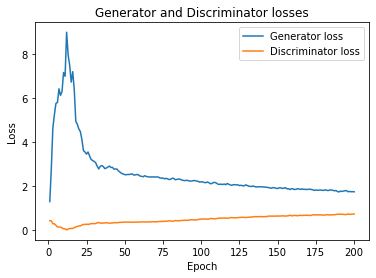

In [14]:
plt.plot(range(1, len(G_loss_per_epoch)+1), G_loss_per_epoch, label='Generator loss')
plt.plot(range(1, len(D_loss_per_epoch)+1), D_loss_per_epoch, label='Discriminator loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Generator and Discriminator losses')
plt.show()

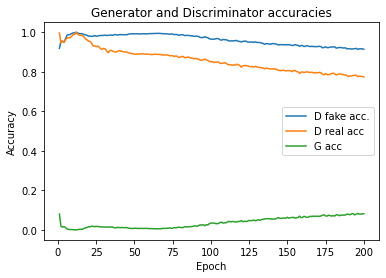

In [15]:
plt.plot(range(1, len(D_fake_acc_per_epoch)+1), D_fake_acc_per_epoch, label='D fake acc.')
plt.plot(range(1, len(D_real_acc_per_epoch)+1), D_real_acc_per_epoch, label='D real acc')
plt.plot(range(1, len(G_acc_per_epoch)+1), G_acc_per_epoch, label='G acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Generator and Discriminator accuracies')
plt.show()

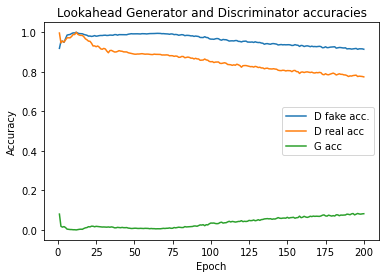

In [16]:
plt.plot(range(1, len(D_fake_acc_per_epoch)+1), D_fake_acc_per_epoch, label='D fake acc.')
plt.plot(range(1, len(D_real_acc_per_epoch)+1), D_real_acc_per_epoch, label='D real acc')
plt.plot(range(1, len(G_acc_per_epoch)+1), G_acc_per_epoch, label='G acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Lookahead Generator and Discriminator accuracies')
plt.show()

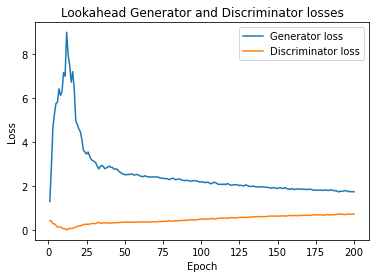

In [17]:
plt.plot(range(1, len(G_loss_per_epoch)+1), G_loss_per_epoch, label='Generator loss')
plt.plot(range(1, len(D_loss_per_epoch)+1), D_loss_per_epoch, label='Discriminator loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Lookahead Generator and Discriminator losses')
plt.show()

### Plot FID

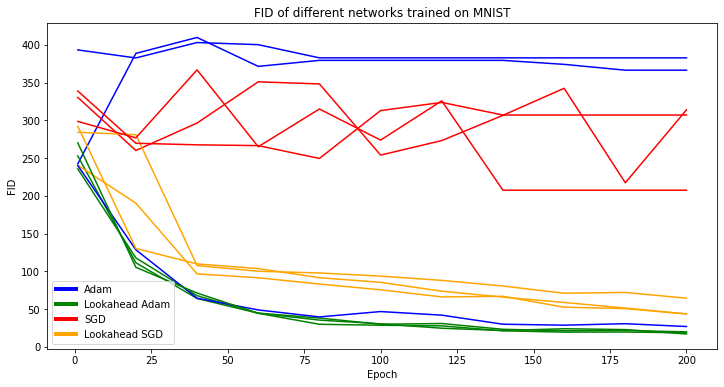

In [44]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='r', lw=4),
               Line2D([0], [0], color='orange', lw=4)]


plt.figure(figsize=(12,6))

colors = ['b', 'g', 'r', 'orange']

for i, k in enumerate(FIDs_dic):
    plt.plot(list_epochs, FIDs_dic[k], label=k, color=colors[i%4])
    
plt.ylabel('FID')
plt.xlabel('Epoch')
plt.legend(custom_lines, ['Adam', 'Lookahead Adam', 'SGD', 'Lookahead SGD'])
#plt.legend(bbox_to_anchor=(1, 1.0))
plt.title('FID of different networks trained on MNIST')
plt.show()

In [45]:
for k in FIDs_dic:
    print('{} : {}'.format(k, min(FIDs_dic[k])))

Adam1 : 242.33152997938177
Lookahead Adam1 : 16.896503602804103
SGD1 : 217.31283835506662
Lookahead SGD1 : 64.32207516007799
Adam2 : 382.74626203172187
Lookahead Adam2 : 19.692679127725967
SGD2 : 249.52867624086815
Lookahead SGD2 : 43.425377491608
Adam3 : 26.76950703983087
Lookahead Adam3 : 18.498372050924644
SGD3 : 207.44632316022523
Lookahead SGD3 : 43.474897003240415
